In [1]:
%load_ext autoreload
%autoreload 2

# Classification Task

In [46]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, ifft

from torchvision import datasets
import torchvision.transforms as transforms
import torch

sys.path.insert(0, '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/lib/')
import MURA as mura

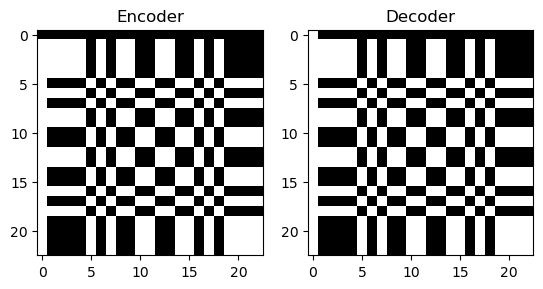

In [5]:
# Test with p=5 to check with paper 
p = 23 # size of array
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].imshow(A, cmap='gray')
axs[1].imshow(G, cmap='gray')
axs[0].set_title("Encoder")
axs[1].set_title("Decoder")
plt.show()

# Load MNIST Data

In [101]:
# Compute MURA encoder and decoder
p = 23 # size of array
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

# Load training and testing data from PyTorch
size = A.shape[0]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    #transforms.Normalize(mean=0., std=(1/255.)),
                    # Apply MURA encoder
                    lambda x: torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(x.numpy()), A,p)), 0),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)
test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    #transforms.Normalize(mean=0., std=(1/255.)),
                    # Apply MURA encoder
                    lambda x: torch.unsqueeze(torch.tensor(mura.FFT_convolve(np.squeeze(x.numpy()), A,p)), 0),
                    transforms.Normalize(0, 1)
                ]) 
)